In [2]:
import numpy as np
import pandas as pd
import pathlib, sys, os, random, time,glob
import  cv2, gc
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import torch
from fastai.vision.all import *
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torchvision
from scipy import sparse
from PIL import Image, ImageOps
import zipfile
from Network import *

'0.5.2'

In [3]:
class CONFIG():
    data_path = '/home/alex/Github/Maya/DiscoverMayaChallenge_data/lidar_test/'
    out_dir='/home/alex/Github/Maya/predictions_mpV2'
    zip_dir='/home/alex/Github/Maya/out'
    MODELS1='/home/alex/Github/Maya_Pytorch/AguadaBest/'  
    MODELS2='/home/alex/Github/Maya_Pytorch/Unext/buildingV1/models/'
    MODELS3='/home/alex/Github/Maya_Pytorch/Unext/platformV1/models/'
    MODELS4='/home/alex/Github/Maya_Pytorch/Unext/buildingV2/models/'  
    MODELS5='/home/alex/Github/Maya_Pytorch/Unext/platformV2/models/'  
    CLASSES=['aguada','building','platform']
    TH =[0.5,0.5,0.5] # sequense: 'aguada','building','platform'
    stats = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
    batch_size = 4 
    
cfg = CONFIG()
print(os.listdir(cfg.MODELS1))   
print(len(os.listdir(cfg.MODELS1))) 

['resnext101_32x4d_swsl_fold0_aguada.pth', 'resnext101_32x4d_swsl_fold1_aguada.pth', 'resnext101_32x4d_swsl_fold4_aguada.pth', 'resnext101_32x4d_swsl_fold3_aguada.pth', 'resnext101_32x4d_swsl_fold2_aguada.pth']
5


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
trfm = A.Compose([
    A.Normalize(cfg.stats[0],cfg.stats[1]),
    ToTensorV2()
])

def get_models(paths):
    models = []
    for path in paths:
        state_dict = torch.load(path,map_location=torch.device('cpu'))
        enc=path.split('/')[-1].split('_')[0]
        encoder_name=enc+'_32x4d_swsl' 
        print('encoder_name:',encoder_name)
        model = UneXt50(encoder_name)
        model = nn.DataParallel(model) 
        model.load_state_dict(state_dict)
        model.float()
        model.eval()
        model.to(device)
        models.append(model)

    del state_dict
    return models

In [6]:
ids=[]
fns=os.listdir(cfg.data_path)
for fn in fns:
    id=fn.split('_')[1]
    ids.append(int(id))
df=pd.DataFrame({'fn':fns,'id':ids})
df

,fn,id
0,tile_1782_lidar.tif,1782
1,tile_2042_lidar.tif,2042
2,tile_1899_lidar.tif,1899
3,tile_1925_lidar.tif,1925
4,tile_1829_lidar.tif,1829
...,...,...
324,tile_1957_lidar.tif,1957
325,tile_2093_lidar.tif,2093
326,tile_1879_lidar.tif,1879
327,tile_2018_lidar.tif,2018


In [7]:
class MayaDataset(Dataset):    
    def __init__(self, img_dir, df,transform=None):
        ids=df.id.values
        self.img_dir = img_dir
        self.transform = transform      
        self.df=df
        self.ids=ids
        print('len=',len(self.ids))

    def __getitem__(self, index):
        id=self.ids[index]
        fn = 'tile_'+str(id)+'_lidar.tif'
        image=cv2.imread(os.path.join(self.img_dir, fn))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image,id 
        
    def __len__(self):
        return len(self.ids)

In [8]:
#iterator like wrapper that returns predicted masks
class Model_pred:
    def __init__(self, models, dl, tta:bool=True, half:bool=False):
        self.models = models
        self.dl = dl
        self.tta = tta
        self.half = half
        
    def __iter__(self):
        count=0
        with torch.no_grad():
            for x,y in iter(self.dl):
                if ((y>=0).sum() > 0): #exclude empty images
                    x = x[y>=0].to(device)
                    y = y[y>=0]
                    if self.half: x = x.half()
                    py = None
                    for model in self.models:
                        p = model(x)
                        p = torch.sigmoid(p).detach()
                        if py is None: py = p
                        else: py += p
                    if self.tta:
                        #x,y,xy flips as TTA
                        flips = [[-1],[-2],[-2,-1]]
                        for f in flips:
                            xf = torch.flip(x,f)
                            for model in self.models:
                                p = model(xf)
                                p = torch.flip(p,f)
                                py += torch.sigmoid(p).detach()
                        py /= (1+len(flips))        
                    py /= len(self.models)
                    py = py.permute(0,2,3,1).float().cpu()
                    batch_size = len(py)
                    for i in range(batch_size):
                        yield py[i],y[i]
                        count += 1
                    
        count=0
    def __len__(self):
        return len(self.dl.dataset)

In [10]:
os.makedirs(cfg.out_dir, exist_ok=True)
os.makedirs(cfg.zip_dir, exist_ok=True)
OUT = {}
ds=MayaDataset(cfg.data_path,df,trfm)
dl = DataLoader(ds,cfg.batch_size,num_workers=0,shuffle=False,pin_memory=True)
for i in range(len(cfg.CLASSES)):
    OUT[i] = []
    prefix=cfg.CLASSES[i]
    mpath = glob.glob(cfg.MODELS1+'*'+prefix+'.pth')
    mpath2 = glob.glob(cfg.MODELS2+'*'+prefix+'.pth')
    mpath3 = glob.glob(cfg.MODELS3+'*'+prefix+'.pth')
    mpath4 = glob.glob(cfg.MODELS4+'*'+prefix+'.pth')
    mpath5 = glob.glob(cfg.MODELS5+'*'+prefix+'.pth')
    mpath=mpath+mpath2+mpath3+mpath4+mpath5
    print('mpath:',len(mpath),prefix)
    models=get_models(mpath)
    ds=MayaDataset(cfg.data_path,df,trfm)
    dl = DataLoader(ds,cfg.batch_size,num_workers=0,shuffle=False,pin_memory=True)
    mp = Model_pred(models,dl)  
    for p in progress_bar(mp):
        id=p[1].cpu().numpy()
        fn=cfg.out_dir+'/tile_'+str(id)+'_mask_'+ prefix +'.png'  
        data = p[0].squeeze(-1).float().cpu().numpy()
        img=(255*data).astype(np.uint8)
        cv2.imwrite(fn,img)
        out= (data < cfg.TH[i]).astype(np.uint8)
        img=np.logical_not(out).astype(np.uint8)
        img_sp=sparse.csr_matrix(Image.fromarray(img*255),dtype=bool)   
        sparse.save_npz(cfg.zip_dir+'/tile_'+str(id)+'_mask_'+ prefix +'.npz', img_sp, compressed=True)
        OUT[i].append(out)
        torch.cuda.empty_cache()
        gc.collect()
        

len= 329
mpath: 5 aguada
encoder_name: resnext101_32x4d_swsl


Using cache found in /home/alex/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


encoder_name: resnext101_32x4d_swsl


Using cache found in /home/alex/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


encoder_name: resnext101_32x4d_swsl


Using cache found in /home/alex/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


encoder_name: resnext101_32x4d_swsl


Using cache found in /home/alex/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


encoder_name: resnext101_32x4d_swsl


Using cache found in /home/alex/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


len= 329


mpath: 8 building
encoder_name: resnext50_32x4d_swsl


Using cache found in /home/alex/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


encoder_name: resnext50_32x4d_swsl


Using cache found in /home/alex/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


encoder_name: resnext50_32x4d_swsl


Using cache found in /home/alex/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


encoder_name: resnext50_32x4d_swsl


Using cache found in /home/alex/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


encoder_name: resnext101_32x4d_swsl


Using cache found in /home/alex/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


encoder_name: resnext101_32x4d_swsl


Using cache found in /home/alex/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


encoder_name: resnext101_32x4d_swsl


Using cache found in /home/alex/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


encoder_name: resnext101_32x4d_swsl


Using cache found in /home/alex/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


len= 329


mpath: 8 platform
encoder_name: resnext50_32x4d_swsl


Using cache found in /home/alex/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


encoder_name: resnext50_32x4d_swsl


Using cache found in /home/alex/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


encoder_name: resnext50_32x4d_swsl


Using cache found in /home/alex/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


encoder_name: resnext50_32x4d_swsl


Using cache found in /home/alex/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


encoder_name: resnext101_32x4d_swsl


Using cache found in /home/alex/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


encoder_name: resnext101_32x4d_swsl


Using cache found in /home/alex/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


encoder_name: resnext101_32x4d_swsl


Using cache found in /home/alex/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


encoder_name: resnext101_32x4d_swsl


Using cache found in /home/alex/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


len= 329


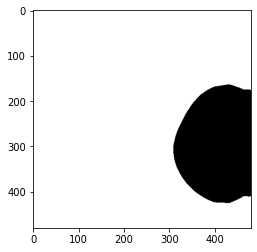

In [10]:
plt.imshow(OUT[0][217],cmap='gray')

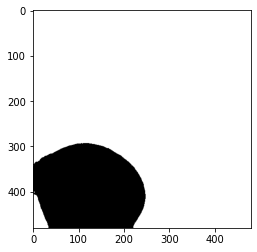

In [12]:
plt.imshow(OUT[0][213],cmap='gray')

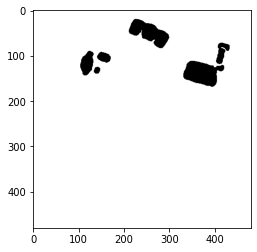

In [27]:
plt.imshow(OUT[1][213],cmap='gray')

In [14]:
def zip(src, dst):
    zf = zipfile.ZipFile("%s.zip" % (dst), "w", zipfile.ZIP_DEFLATED)
    abs_src = os.path.abspath(src)
    for dirname, subdirs, files in os.walk(src):
        for filename in files:
            absname = os.path.abspath(os.path.join(dirname, filename))
            arcname = absname[len(abs_src) + 1:]
            zf.write(absname, arcname)
    zf.close()

In [15]:
zip(cfg.zip_dir, 'out')